In [1]:
%load_ext autoreload
%autoreload 2

from pdac_utils import *
from IPython.display import Image
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
from glob import glob
from matplotlib import pyplot as plt
import os
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)

/home/unix/kjag/.conda/envs/pegasus/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
genemarkers = load_genemarkers()
pid_versions = get_pid_version_map()
broad_celltypes = get_broad_celltypes()

In [3]:
combinetreateddata = sc.read("data/combinetreateddata-reprocessed-clean.h5ad")

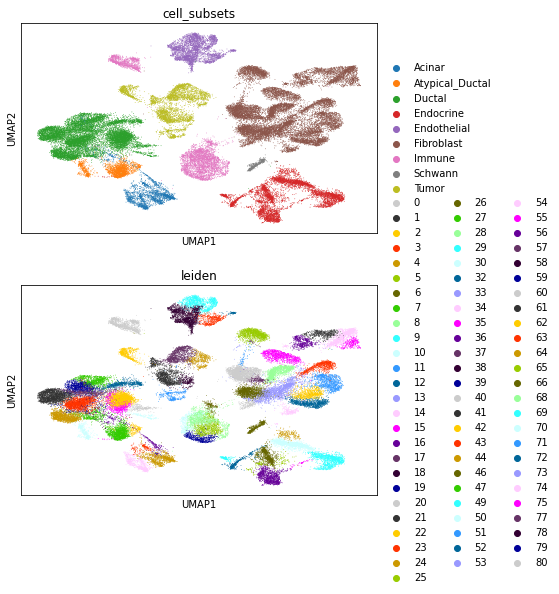

In [4]:
sc.pl.umap(combinetreateddata, color=['cell_subsets', 'leiden'], ncols=1)

computing PCA with n_comps = 50
    on highly variable genes
    finished (0:03:12)
computing neighbors
    using 'X_pca' with n_pcs = 50


/home/unix/kjag/.conda/envs/pegasus/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../home/unix/kjag/.conda/envs/pegasus/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/unix/kjag/.conda/envs/pegasus/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../..

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:13)
running Leiden clustering
    finished: found 52 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)


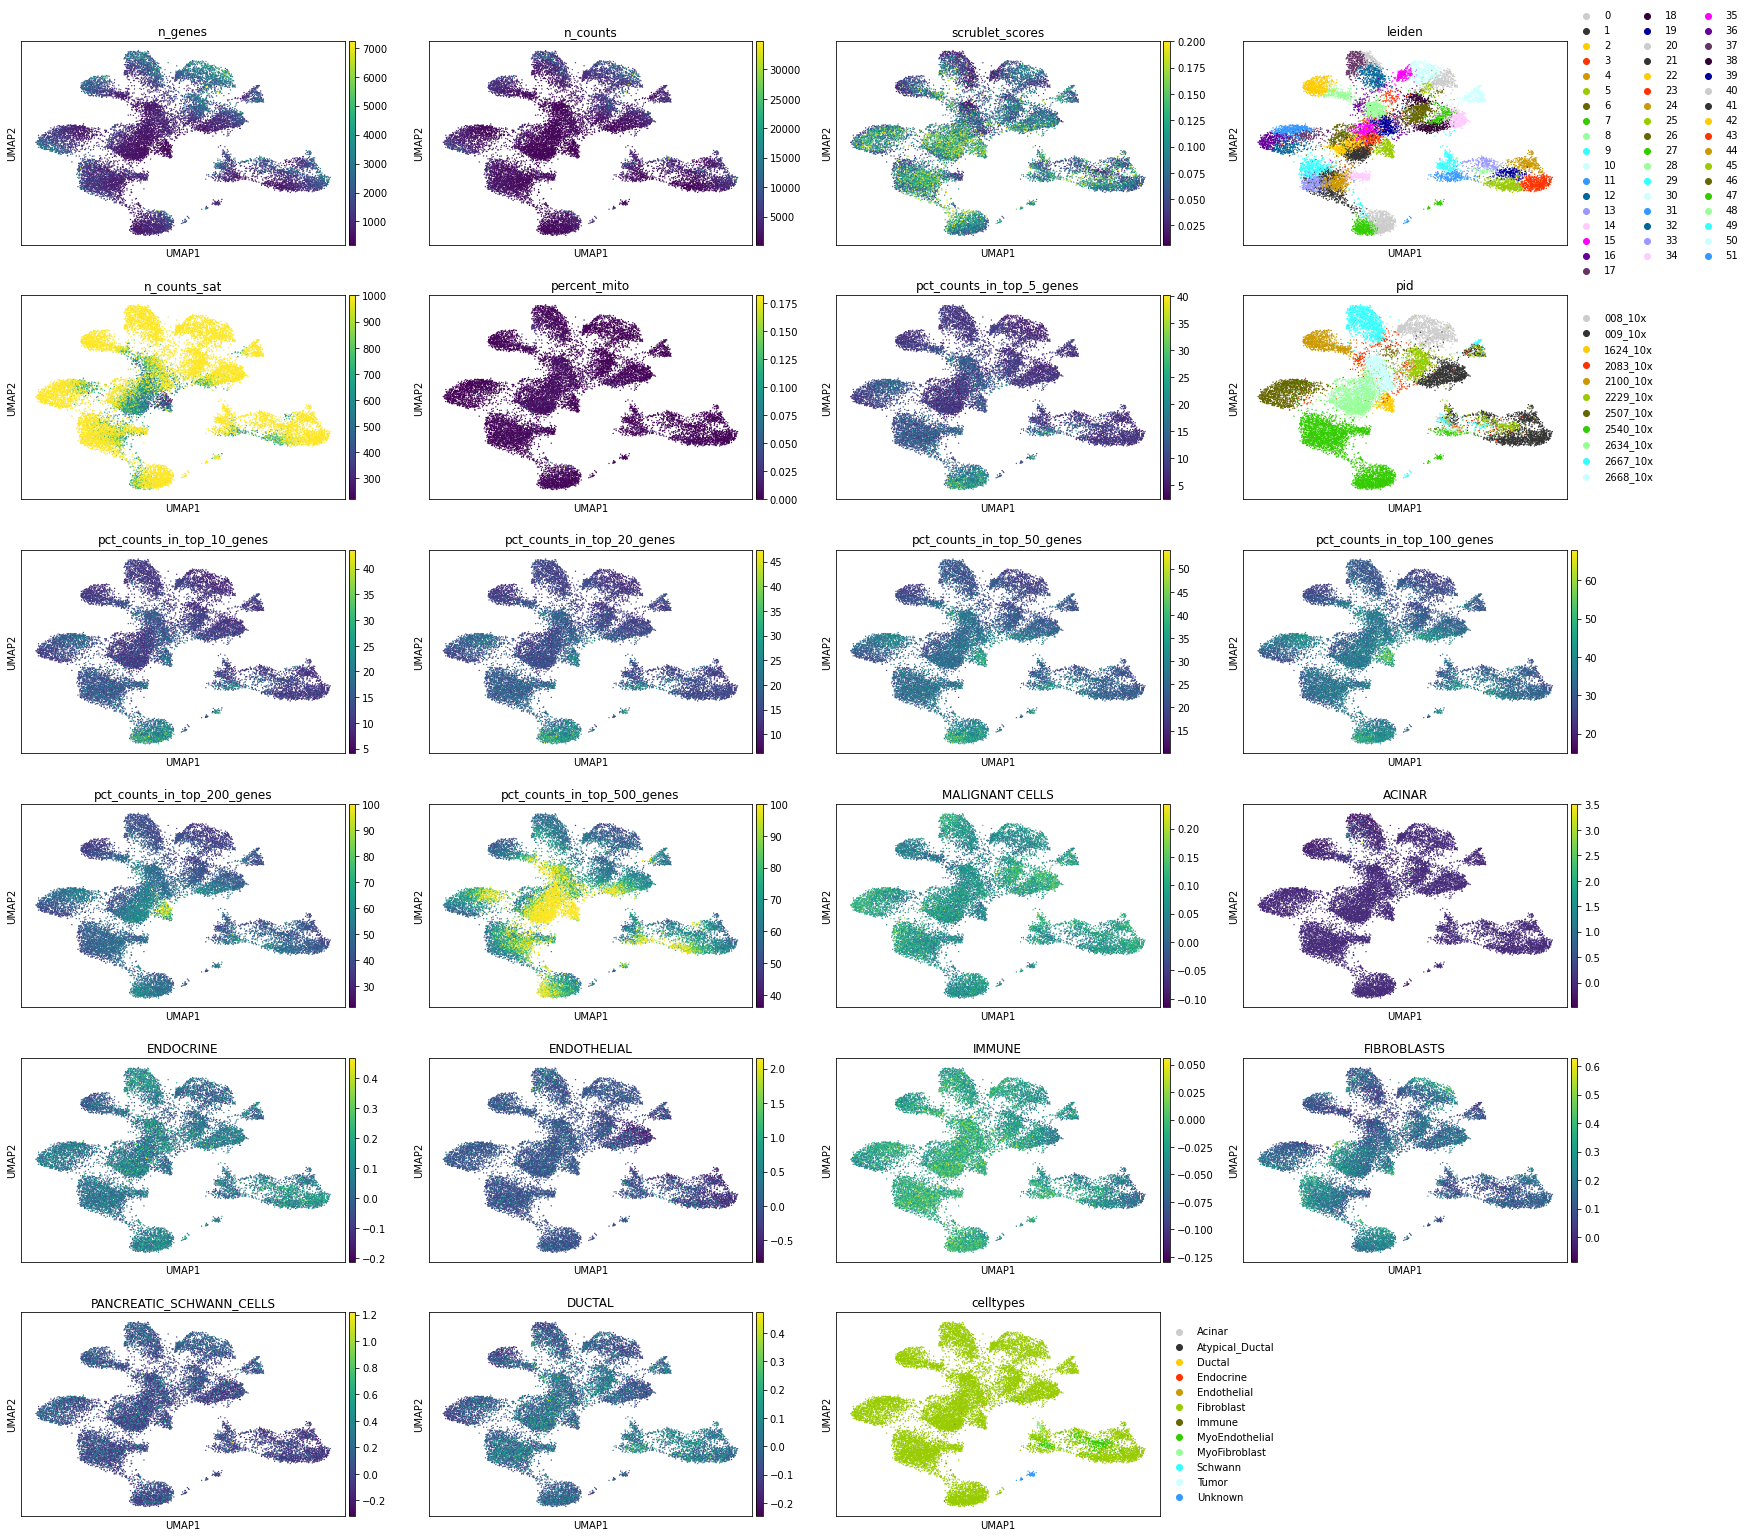

In [5]:
subsetdata = combinetreateddata[combinetreateddata.obs['cell_subsets']=='Fibroblast']
subsetdata = recompute_umap(subsetdata)
#subsetdata.write('/ahg/regevdata/projects/Pancreas/src/treatedfibroblast_nmf.h5ad')

In [7]:
subsetdata.write('/ahg/regevdata/projects/Pancreas/src/treatedfibroblast_nmf.h5ad')

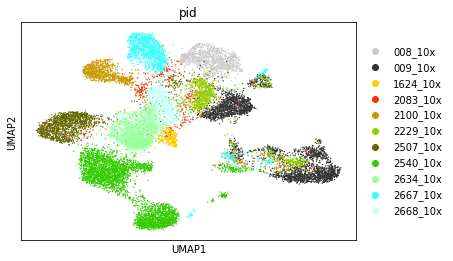

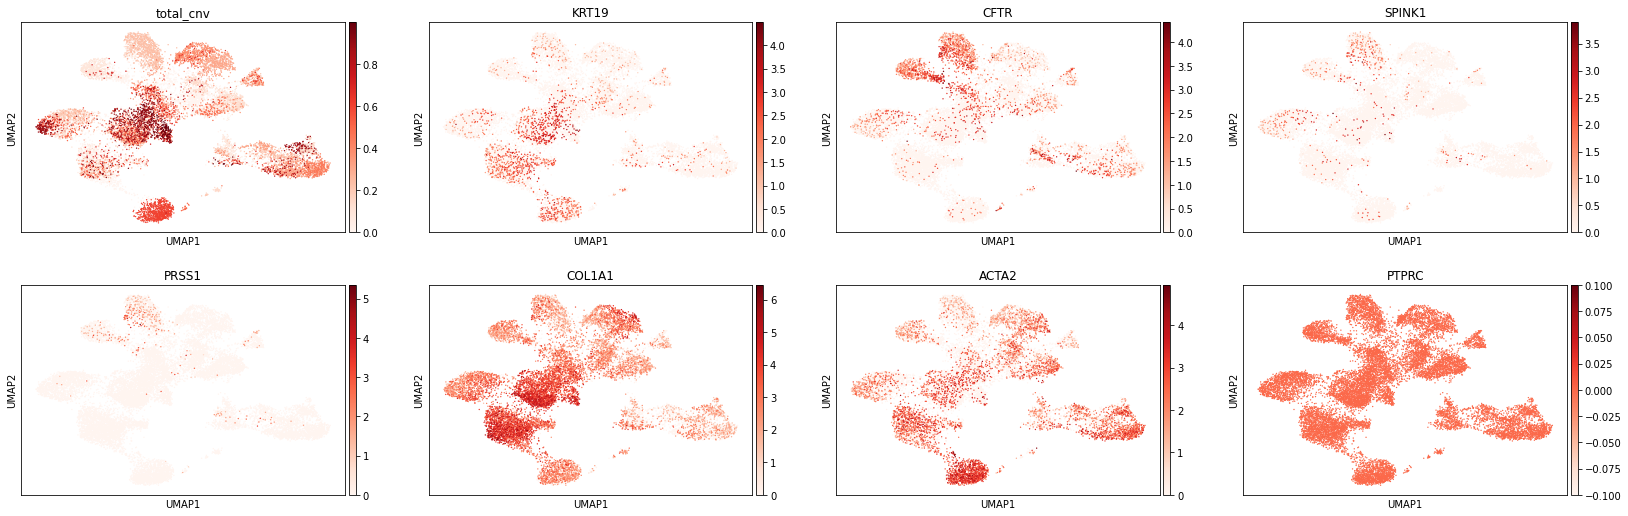

In [6]:
sc.pl.umap(subsetdata, color='pid')
sc.pl.umap(subsetdata, color=['total_cnv', 'KRT19', 'CFTR', 'SPINK1', 'PRSS1', 'COL1A1', 'ACTA2', 'PTPRC'], color_map='Reds')

In [3]:
subsetdata = sc.read('/ahg/regevdata/projects/Pancreas/src/treatedfibroblast_nmf.h5ad')

In [4]:
! lscpu

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                16
On-line CPU(s) list:   0-15
Thread(s) per core:    1
Core(s) per socket:    8
Socket(s):             2
NUMA node(s):          1
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 45
Model name:            Intel(R) Xeon(R) CPU E5-2680 0 @ 2.70GHz
Stepping:              7
CPU MHz:               2700.000
CPU max MHz:           2700.0000
CPU min MHz:           1200.0000
BogoMIPS:              5399.93
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              20480K
NUMA node0 CPU(s):     0-15
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc aperfmperf eagerfpu pni p

In [5]:
numiter=50 # Number of NMF replicates. Set this to a larger value ~200 for real data. We set this to a relatively low value here for illustration at a faster speed
numworkers=50
numhvgenes=subsetdata.shape[1] ## Number of over-dispersed genes to use for running the actual factorizations

basedir = '/ahg/regevdata/projects/Pancreas/src'

## Results will be saved to [output_directory]/[run_name] which in this example is example_PBMC/cNMF/pbmc_cNMF
output_directory = basedir + '/cNMF/treated_fibroblast_cNMF'
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
run_name = 'pbmc_cNMF2'

## To speed this up, you can run it for only K=7-8 with the option below
K = ' '.join([str(i) for i in range(3,8)])


seed = 14 ## Specify a seed pseudorandom number generation for reproducibility

## Path to the filtered counts dataset we output previously
countfn = '/ahg/regevdata/projects/Pancreas/src/treatedfibroblast_nmf.h5ad'

In [10]:
prepare_cmd = '/home/unix/kjag/.conda/envs/pegasus/bin/python cnmf.py prepare --output-dir %s --name %s -c %s -k %s --n-iter %d --total-workers %d --seed %d --numgenes %d --beta-loss frobenius' % (output_directory, run_name, countfn, K, numiter, numworkers, seed, numhvgenes)
print('Prepare command assuming parallelization with %d cores:\n%s' % (numworkers, prepare_cmd))
! {prepare_cmd}

Prepare command assuming parallelization with 50 cores:
/home/unix/kjag/.conda/envs/pegasus/bin/python cnmf.py prepare --output-dir /ahg/regevdata/projects/Pancreas/src/cNMF/treated_fibroblast_cNMF --name pbmc_cNMF2 -c /ahg/regevdata/projects/Pancreas/src/treatedfibroblast_nmf.h5ad -k 3 4 5 6 7 --n-iter 50 --total-workers 50 --seed 14 --numgenes 22164 --beta-loss frobenius
/home/unix/kjag/.conda/envs/pegasus/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
(16230, 22164)
/home/unix/kjag/.conda/envs/pegasus/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:909: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/unix/kjag/.conda/envs/pegasus/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:1225: RuntimeWarning: divide by zero encoun

In [11]:
"""## Submitting all of the factorization jobs for the 0th (I.e. the only) worker
factorize_cmd = '/home/unix/kjag/.conda/envs/pegasus/bin/python cnmf.py factorize --output-dir %s --name %s --worker-index 0' % (output_directory, run_name)
print('Factorize command with no parallelization:\n%s' % factorize_cmd)
!{factorize_cmd}
"""
## Using GNU parallel
## This took 4 minutes in our testing
worker_index = ' '.join([str(x) for x in range(numworkers)])
factorize_cmd = '/home/unix/kjag/.conda/envs/pegasus/bin/python %s/cnmf.py factorize --output-dir %s --name %s --worker-index %s --total-workers %d'
commands = []
for i in worker_index.split(' '):
    commands.append(factorize_cmd%(basedir, output_directory, run_name, i, numworkers))
commands = "\n".join(commands)
print('Factorize command to simultaneously run factorization over %d cores using GNU parallel:\n%s' % (numworkers, commands))

joblist = open(output_directory+"/joblist", "w")
joblist.write(commands)
joblist.close()
#!{commands}

Factorize command to simultaneously run factorization over 50 cores using GNU parallel:
/home/unix/kjag/.conda/envs/pegasus/bin/python /ahg/regevdata/projects/Pancreas/src/cnmf.py factorize --output-dir /ahg/regevdata/projects/Pancreas/src/cNMF/treated_fibroblast_cNMF --name pbmc_cNMF2 --worker-index 0 --total-workers 50
/home/unix/kjag/.conda/envs/pegasus/bin/python /ahg/regevdata/projects/Pancreas/src/cnmf.py factorize --output-dir /ahg/regevdata/projects/Pancreas/src/cNMF/treated_fibroblast_cNMF --name pbmc_cNMF2 --worker-index 1 --total-workers 50
/home/unix/kjag/.conda/envs/pegasus/bin/python /ahg/regevdata/projects/Pancreas/src/cnmf.py factorize --output-dir /ahg/regevdata/projects/Pancreas/src/cNMF/treated_fibroblast_cNMF --name pbmc_cNMF2 --worker-index 2 --total-workers 50
/home/unix/kjag/.conda/envs/pegasus/bin/python /ahg/regevdata/projects/Pancreas/src/cnmf.py factorize --output-dir /ahg/regevdata/projects/Pancreas/src/cNMF/treated_fibroblast_cNMF --name pbmc_cNMF2 --worker

In [6]:
cmd = '/home/unix/kjag/.conda/envs/pegasus/bin/python cnmf.py combine --output-dir %s --name %s' % (output_directory, run_name)
print(cmd)
!{cmd}

/home/unix/kjag/.conda/envs/pegasus/bin/python cnmf.py combine --output-dir /ahg/regevdata/projects/Pancreas/src/cNMF/treated_fibroblast_cNMF --name pbmc_cNMF2
/home/unix/kjag/.conda/envs/pegasus/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Combining factorizations for k=3.
/home/unix/kjag/.conda/envs/pegasus/lib/python3.7/site-packages/numpy/lib/format.py:356: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
Combining factorizations for k=4.
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.


In [7]:
worker_index = ' '.join([str(x) for x in range(1)])
kselect_plot_cmd = '/home/unix/kjag/.conda/envs/pegasus/bin/python cnmf.py k_selection_plot --output-dir %s --name %s' % (output_directory, run_name)
print('K selection plot command: %s' % kselect_plot_cmd)
!{kselect_plot_cmd}

K selection plot command: /home/unix/kjag/.conda/envs/pegasus/bin/python cnmf.py k_selection_plot --output-dir /ahg/regevdata/projects/Pancreas/src/cNMF/treated_fibroblast_cNMF --name pbmc_cNMF2
/home/unix/kjag/.conda/envs/pegasus/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


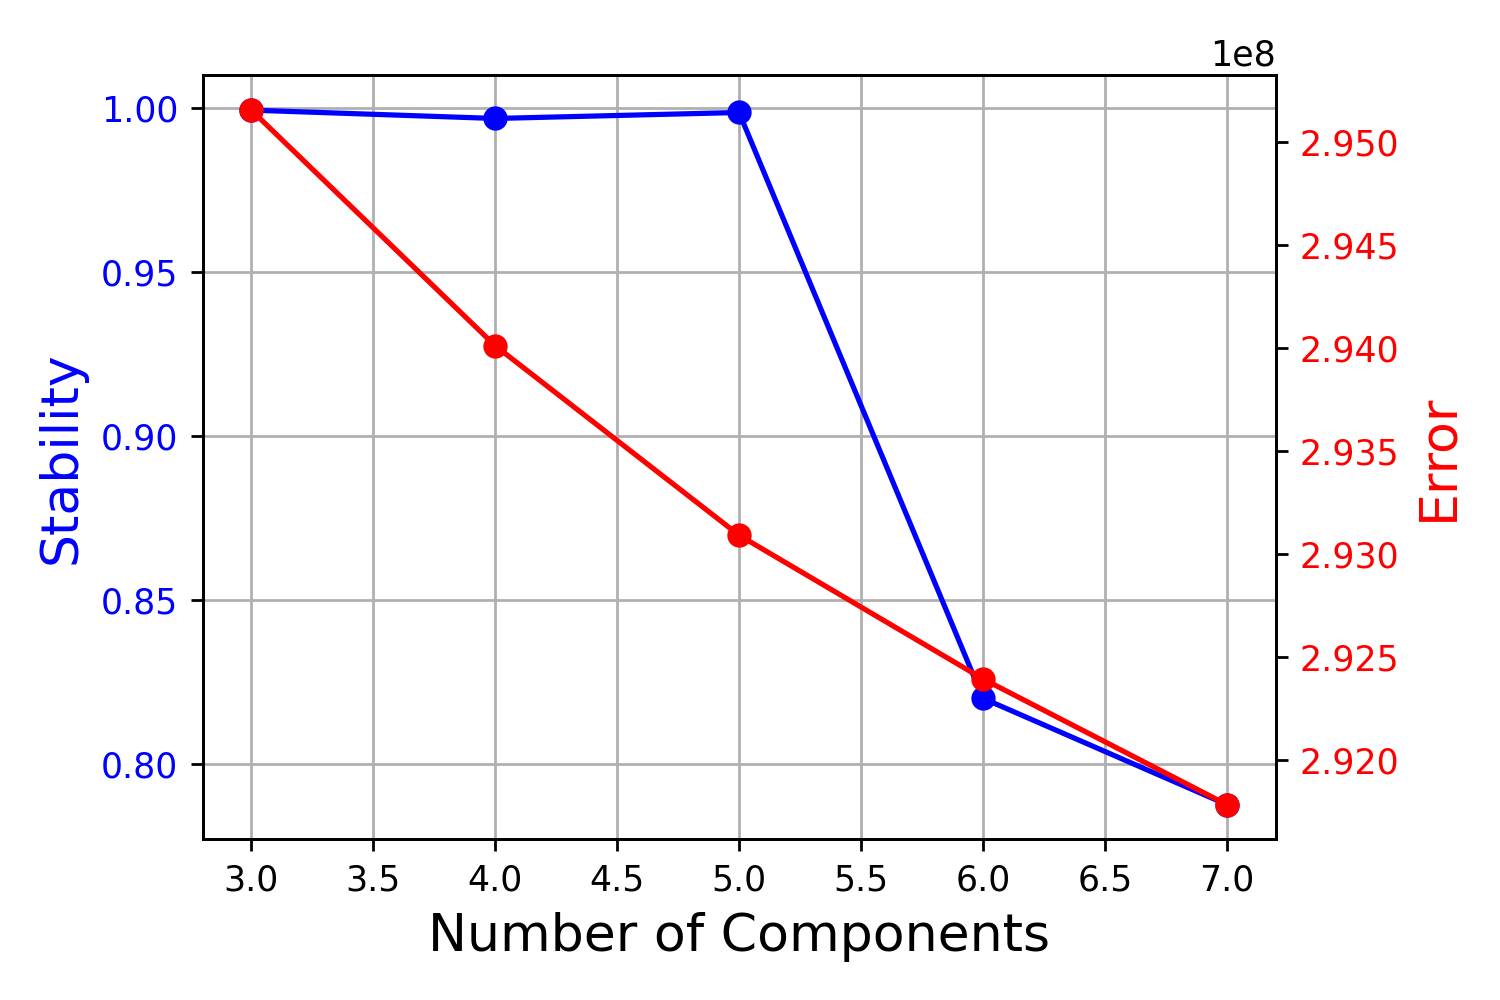

In [6]:
Image(filename = "cNMF/treated_fibroblast_cNMF/pbmc_cNMF2/pbmc_cNMF2.k_selection.png", width=1000, height=1000)

In [7]:
selected_K = 4
density_threshold = 2.00

In [8]:
## This is the command you would run from the command line to obtain the consensus estimate with no filtering
## and to save a diagnostic plot as a PDF
consensus_cmd = '/home/unix/kjag/.conda/envs/pegasus/bin/python cnmf.py consensus --output-dir %s --name %s --local-density-threshold %.2f --components %d --show-clustering' % (output_directory, run_name, density_threshold, selected_K)
print('Consensus command for K=%d:\n%s' % (selected_K, consensus_cmd))
!{consensus_cmd}

Consensus command for K=4:
/home/unix/kjag/.conda/envs/pegasus/bin/python cnmf.py consensus --output-dir /ahg/regevdata/projects/Pancreas/src/cNMF/treated_fibroblast_cNMF --name pbmc_cNMF2 --local-density-threshold 2.00 --components 4 --show-clustering
/home/unix/kjag/.conda/envs/pegasus/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/unix/kjag/.conda/envs/pegasus/lib/python3.7/site-packages/numpy/lib/format.py:356: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
cnmf.py:568: RuntimeWarning: invalid value encountered in true_divide
  norm_tpm = (np.array(tpm.X.todense()) - tpm_stats['__mean'].values) / tpm_stats['__std'].values
/home/unix/kjag/.conda/envs/pegasus/lib

In [9]:
density_threshold_str = ('%.2f' % density_threshold).replace('.', '_')
Image(filename = "cNMF/treated_fibroblast_cNMF/%s/%s.clustering.k_%d.dt_%s.png" % (run_name, run_name, selected_K, density_threshold_str), width=1000, height=1000)

FileNotFoundError: [Errno 2] No such file or directory: 'cNMF/treated_fibroblast_cNMF/pbmc_cNMF2/pbmc_cNMF2.clustering.k_4.dt_2_00.png'

In [10]:
subsetdata = sc.read('/ahg/regevdata/projects/Pancreas/src/treatedfibroblast_nmf.h5ad')

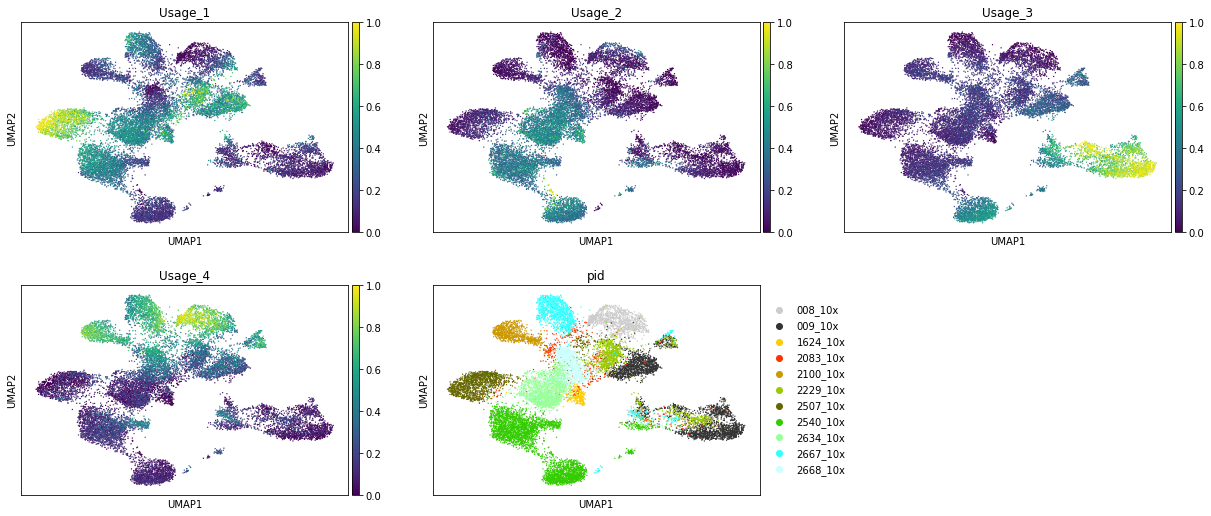

In [11]:
usage = pd.read_csv('./cNMF/treated_fibroblast_cNMF/pbmc_cNMF2/pbmc_cNMF2.usages.k_%d.dt_%s.consensus.txt' % (selected_K, density_threshold_str),
                    sep='\t', index_col=0)
usage.columns = ['Usage_%s' % i for i in usage.columns]
usage_norm = usage.div(usage.sum(axis=1), axis=0)
subsetdata.obs = pd.merge(left=subsetdata.obs, right=usage_norm, how='left', left_index=True, right_index=True)
sc.pl.umap(subsetdata, color=list(usage_norm.columns) + ['pid'], ncols=3, vmin=0, vmax=1, save="04242020_treated_fibroblast_%d.png"%selected_K)

In [12]:
## Load the Z-scored GEPs which reflect how enriched a gene is in each GEP relative to all of the others
gene_scores = pd.read_csv('./cNMF/treated_fibroblast_cNMF/pbmc_cNMF2/pbmc_cNMF2.gene_spectra_score.k_%d.dt_%s.txt' % (selected_K, density_threshold_str),
                    sep='\t', index_col=0).T

## Obtain the top 100 genes for each GEP in sorted order and combine them into a single dataframe
top_genes = []
ngenes = 200
for gep in gene_scores.columns:
    top_genes.append(list(gene_scores.sort_values(by=gep, ascending=False).index[:ngenes]))
    
top_genes = pd.DataFrame(top_genes, index=gene_scores.columns).T
top_genes

,1,2,3,4
0,SAMD4A,ODF1,KCNAB1,C7
1,COL12A1,TMSB10,RCAN2,SCN7A
2,SERPINE1,RPLP1,DGKG,ABCA6
3,MYOF,FTL,NTRK3,SLIT2
4,FN1,LGALS1,AKAP6,ABCA10
...,...,...,...,...
195,LIMS1,CD63,IL6R,ADH1B
196,SAT1,PPIA,SBSPON,PRKAG2
197,FGF7,PRDX1,ARHGAP10,UTRN
198,MYH10,ZNF37A,ATP8B1,JPX


In [13]:
top_genes.T.to_csv('/ahg/regevdata/projects/Pancreas/src/cNMF/treated_fibroblast_cNMF/20200424_treatedfibroblast_topics.%d.txt'%selected_K)

In [14]:
subsetdata.obsm['usage_nmf%d'%selected_K] = usage.values
subsetdata.varm['genescores_nmf%d'%selected_K] = gene_scores.values

In [15]:
subsetdata.write('/ahg/regevdata/projects/Pancreas/src/cNMF/treated_fibroblast_cNMF/treatedfibroblastNMF.h5ad')